# Forecasting Stock Price Movement using Machine Learning

In [42]:
__author__ = 'Saddam Chowdhury'  
__email__ = 'saddam.chw@gmail.com'
__date__ = '14 June 2019'

### Install Keras

In [26]:
# !pip install keras

  Using cached https://files.pythonhosted.org/packages/5e/10/aa32dad071ce52b5502266b5c659451cfd6ffcbf14e6c8c4f16c0ff5aaab/Keras-2.2.4-py2.py3-none-any.whl
  Using cached https://files.pythonhosted.org/packages/28/6a/8c1f62c37212d9fc441a7e26736df51ce6f0e38455816445471f10da4f0a/Keras_Preprocessing-1.1.0-py2.py3-none-any.whl


### Data and file preprocessing

In [43]:
import pandas as pd
import os
import glob
import numpy as np

#set PATH to the current directory where this notebook is saved
PATH = '/content/datalab/exam/' 
os.chdir(PATH)
extension = 'csv'
# Change to directory where the stock data have been saved
os.chdir('stock_data/')
# Get the names of all the .csv files
files = glob.glob('*.{}'.format(extension))

for i, file_name in enumerate(files):
  print(i, files[i])

(0, 'close_prices.csv')
(1, 'signals_B.csv')
(2, 'high_prices.csv')
(3, 'volume.csv')
(4, 'low_prices.csv')
(5, 'close_returns.csv')
(6, 'signals_A.csv')
(7, 'open_prices.csv')


In [3]:
# Set parameters
look_back = 24
batch_size = 20
lr = 0.0001
epochs = 50
sample_ID_index = 4

In [4]:
# Reading all the .csv files and saving as a dictionary

os.chdir(PATH)
df = {}
for i,file_name in enumerate(files):
  df[i] = pd.read_csv('stock_data/{}'.format(file_name))
  df[i].set_index('time', inplace=True)

In [5]:
print "Size of each dataframe in the dictionary", df[0].shape 
nRows = df[0].shape[0]


Size of each dataframe in the dictionary (6518, 1000)


In [6]:
stock = {}
# Total number of stocks
stockCount = df[0].shape[1]

cols = ['Close', 'SignalsB', 'High', 'Volume', 'Low', 'Return', 'SignalsA', 'Open']
new_cols = ['Open', 'High', 'Low', 'Close', 'Volume', 'Return', 'SignalsA', 'SignalsB']

# Create dataframes containing all stock data information for each stock ID and save them in a dictionary
for i in range(stockCount):
  dataset = pd.DataFrame()
  for j, col in enumerate(cols):
    dataset[col] = df[j].iloc[:,i]
  stock[i] = dataset
  stock[i] = stock[i][new_cols]

# sample of a dataframe corresponding to Stock ID: 2

stock[2].head()

,Open,High,Low,Close,Volume,Return,SignalsA,SignalsB
time,,,,,,,,
2017-01-03 09:30:00,31.663986,31.849971,31.524496,31.803475,14315.0,NaN,NaN,NaN
2017-01-03 09:45:00,31.524379,31.616961,31.431797,31.616961,4877.0,-0.005865,-0.004409,NaN
2017-01-03 10:00:00,31.505340,31.874904,31.505340,31.828709,8439.0,0.006697,-0.000604,NaN
2017-01-03 10:15:00,32.070833,32.117312,32.024354,32.024354,7374.0,0.006147,0.017949,NaN
2017-01-03 10:30:00,32.244527,32.291326,32.197727,32.291326,11716.0,0.008337,0.005416,NaN


### Dealing with missing data

In [7]:
# For convenience, I will consider the files with any of its columns 
# having more than 100 (100 out of 6518 records) missing values to be bad files (bad data)
# and in this project will ignore those files
countMissing = []
for i in range(stockCount):
  totalRecords = stock[i].shape[0]
  missingRecordsMax = stock[i].iloc[:,[0,1,2,3,4,7]].isnull().sum().max()
  if missingRecordsMax > 100:
    countMissing.append(i)

In [8]:
import random
from random import seed

seed(1)
stockList = []
for i in range(stockCount):
  if i not in countMissing:
    stockList.append(i)

# Randomly selecting 20 files (stock data for 20 stocks) out of the good files (good data)
stock_samples = random.sample(stockList, 20)
print "The are total of {} good files.\n".format(len(stockList))
print "Randomly selected 20 stock_ID from the good data files:" 
print stock_samples  

The are total of 647 good files.

Randomly selected 20 stock_ID from the good data files:
[126, 860, 776, 244, 485, 435, 663, 801, 82, 23, 847, 418, 775, 1, 432, 736, 219, 948, 908, 24]


In [9]:
# Chosing any stock ID from the above list
# In the following, I have chosen the index 11 from the above list which corresponds to Stock ID 418 
index = stock_samples[sample_ID_index]
stock[index].describe()

,Open,High,Low,Close,Volume,Return,SignalsA,SignalsB
count,6500.000000,6500.000000,6500.000000,6500.000000,6507.000000,6493.000000,6493.000000,6498.000000
mean,45.297221,45.352391,45.239400,45.295735,6978.093899,0.000034,0.000032,1.052371
std,1.725468,1.727905,1.723709,1.726614,8188.051868,0.008437,0.008520,1.081840
min,41.641983,41.690113,41.603479,41.656552,14.000000,-0.028578,-0.037689,0.001178
25%,44.048594,44.099090,43.980929,44.035525,2942.000000,-0.005813,-0.005954,0.455144
50%,45.120524,45.179535,45.064981,45.128584,4642.000000,0.000031,0.000131,0.717034
75%,46.254890,46.324774,46.203180,46.267605,7604.000000,0.006006,0.006158,1.184588
max,50.388141,50.388141,50.388141,50.388141,173460.000000,0.024974,0.031117,10.692458


In [10]:
stock[index].head()

,Open,High,Low,Close,Volume,Return,SignalsA,SignalsB
time,,,,,,,,
2017-01-03 09:30:00,43.490141,43.490141,42.956971,43.048897,11369.0,NaN,NaN,NaN
2017-01-03 09:45:00,43.058361,43.381691,43.058361,43.330882,9433.0,0.006550,-0.009928,NaN
2017-01-03 10:00:00,43.196339,43.482346,43.177886,43.426990,10696.0,0.002218,0.003204,NaN
2017-01-03 10:15:00,43.402033,43.761489,43.402033,43.731719,16277.0,0.007017,0.004762,NaN
2017-01-03 10:30:00,43.935974,43.945233,43.750786,43.769305,4134.0,0.000859,0.012302,NaN


In [11]:
import copy 

stock_data = copy.deepcopy(stock)
print "Total number of missing values in each column:"
print
print stock_data[index].isnull().sum()

Total number of missing values in each column:

Open        18
High        18
Low         18
Close       18
Volume      11
Return      25
SignalsA    25
SignalsB    20
dtype: int64


In [12]:
# Apply linear interpolation to fill the missing data

stock_data[index].interpolate(method='linear', limit_direction='both', inplace=True, axis=0)
stock_data[index].describe()

,Open,High,Low,Close,Volume,Return,SignalsA,SignalsB
count,6518.000000,6518.000000,6518.000000,6518.000000,6518.000000,6518.000000,6518.000000,6518.000000
mean,45.299895,45.355066,45.242043,45.298409,6972.006520,0.000055,0.000052,1.051031
std,1.726537,1.728884,1.724472,1.727293,8183.036502,0.008434,0.008521,1.080631
min,41.641983,41.690113,41.603479,41.656552,14.000000,-0.028578,-0.037689,0.001178
25%,44.051836,44.100794,43.984138,44.041324,2940.250000,-0.005777,-0.005945,0.454869
50%,45.124034,45.181297,45.068156,45.132886,4640.500000,0.000049,0.000153,0.716771
75%,46.255937,46.325325,46.203401,46.267848,7599.750000,0.006053,0.006192,1.182664
max,50.388141,50.388141,50.388141,50.388141,173460.000000,0.024974,0.031117,10.692458


In [13]:
print "Total number of missing values in each column:"
print
print stock_data[index].isnull().sum()

Total number of missing values in each column:

Open        0
High        0
Low         0
Close       0
Volume      0
Return      0
SignalsA    0
SignalsB    0
dtype: int64


In [14]:
if 'time' not in list(stock_data[index].columns):
    stock_data[index].reset_index(inplace=True)
stock_data[index].head(15)

,time,Open,High,Low,Close,Volume,Return,SignalsA,SignalsB
0,2017-01-03 09:30:00,43.490141,43.490141,42.956971,43.048897,11369.0,0.006550,-0.009928,0.966410
1,2017-01-03 09:45:00,43.058361,43.381691,43.058361,43.330882,9433.0,0.006550,-0.009928,0.966410
2,2017-01-03 10:00:00,43.196339,43.482346,43.177886,43.426990,10696.0,0.002218,0.003204,0.966410
3,2017-01-03 10:15:00,43.402033,43.761489,43.402033,43.731719,16277.0,0.007017,0.004762,0.966410
4,2017-01-03 10:30:00,43.935974,43.945233,43.750786,43.769305,4134.0,0.000859,0.012302,0.966410
5,2017-01-03 10:45:00,43.881379,43.909233,43.779243,43.872093,4658.0,0.002348,-0.001243,0.966410
6,2017-01-03 11:00:00,43.794914,43.869064,43.743936,43.795006,11717.0,-0.001757,-0.001970,0.966410
7,2017-01-03 11:15:00,43.726273,43.726273,43.597784,43.607034,8501.0,-0.004292,-0.001567,0.966410
8,2017-01-03 11:30:00,43.228933,43.439806,43.219765,43.412301,24281.0,-0.004466,-0.011374,0.966410
9,2017-01-03 11:45:00,43.876745,44.025009,43.848946,43.987943,10812.0,0.013260,0.014986,0.966410


### Data Visualization

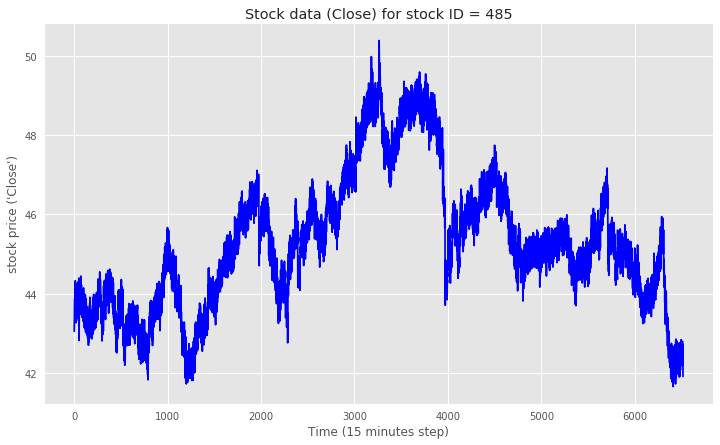

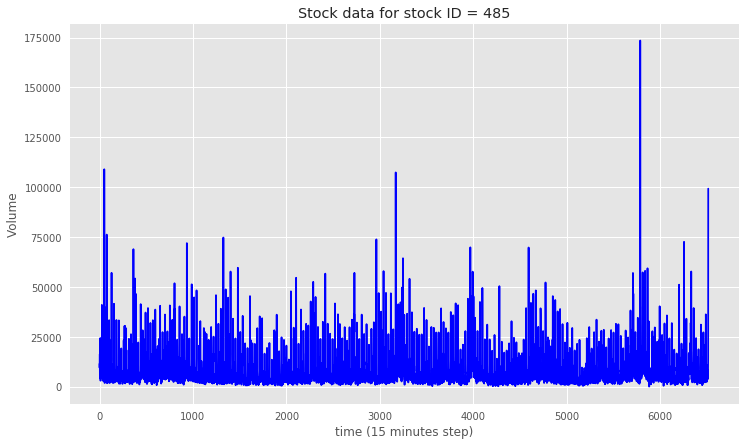

In [37]:
from matplotlib import pyplot as plt
from matplotlib import style

style.use('ggplot')

plt.figure(figsize=(12,7))
plt.plot(stock_data[index]['Close'], 'b-')
plt.title('Stock data (Close) for stock ID = {}'.format(index))
plt.ylabel("stock price ('Close')")
plt.xlabel('Time (15 minutes step)')

plt.figure(figsize=(12,7))
plt.plot(stock_data[index]['Volume'], 'b-')
plt.title('Stock data for stock ID = {}'.format(index))
plt.ylabel('Volume')
plt.xlabel("time (15 minutes step)")
plt.show()

### Feature Engineering

I have added a few extra features in addition to the ones provided. Since the price/volume of the stocks depends on which days of the week and hours of the day it is traded, therefore day of the week and hours of the day have been included in the model estimation. The other feautures included are as follows.

MomentumA = (Open - Close) * Log(Volume)

MomentumB = (C - L14) / (H14 - L14),       
MomentumC = (H14 - C) / (H14 - L14)

where, C = current closing price,   
       L14 = Lowest Low over the past 14 time steps,  
       H14 = Highest High over the past 14 time steps  


HL_diff = High - Low

OC_diff = Open - Close

Relative Strength, RS = Average gain over past 14 days / Average loss over past 14 days

In [16]:
import copy 
from datetime import datetime

df_stock = copy.deepcopy(stock_data[index])
print df_stock.shape

df_stock['DayOfWeek'] = df_stock['time'].apply(
                                  lambda x : datetime.strptime(x, '%Y-%m-%d %H:%M:%S').weekday()) 
df_stock['HourOfDay'] = df_stock['time'].apply(
                                    lambda x : datetime.strptime(x, '%Y-%m-%d %H:%M:%S').hour)
df_stock['logVolume'] = df_stock['Volume'].apply(lambda x: np.log(x + 1))
df_stock['MomentumA'] = df_stock['logVolume'] * (df_stock['Open'] - df_stock['Close'])
df_stock['HL_diff'] = df_stock['High'] - df_stock['Low']
df_stock['OC_diff'] = df_stock['Open'] - df_stock['Close']

highMax = []
lowMin = []
for i in range(14):
  highMax.append(max(df_stock['High'][:i+1]))
  lowMin.append(min(df_stock['Low'][:i+1]))

for i in range(14, len(df_stock)):
  highMax.append(max(df_stock['High'][i-14:i]))
  lowMin.append(min(df_stock['Low'][i-14:i]))

MomentumB = []
MomentumC = []
for i in range(len(df_stock)):
  MomentumB.append((df_stock['Close'].iloc[i] - lowMin[i]) / (highMax[i] - lowMin[i]))
  MomentumC.append((highMax[i] - df_stock['Close'].iloc[i]) / (highMax[i] - lowMin[i]))

df_stock['MomentumB'] = MomentumB
df_stock['MomentumC'] = MomentumC

gain = [0]*len(df_stock)
loss = [0]*len(df_stock)
for i in range(1, len(df_stock)):
  change = df_stock['Close'][i] - df_stock['Close'][i-1]
  if change > 0:
    gain[i] = change
  else:
    loss[i] = abs(change)

avgGain = []
avgLoss = []

for i in range(14):
  avgGain.append(sum(gain[:i+1])/(i+1))
  avgLoss.append(sum(loss[:i+1])/(i+1))

for i in range(14, len(df_stock)):
  avgGain.append(sum(gain[i-14:i])/14)
  avgLoss.append(sum(loss[i-14:i])/14)

rs = []
for i in range(len(df_stock)):
  rs.append( (avgGain[i]+0.0001) / (avgLoss[i]+0.0001) )
  
df_stock['RS'] = rs

(6518, 9)


In [17]:
# Sample of the entire dataset
dataset = copy.deepcopy(df_stock)
dataset.head()

,time,Open,High,Low,Close,Volume,Return,SignalsA,SignalsB,DayOfWeek,HourOfDay,logVolume,MomentumA,HL_diff,OC_diff,MomentumB,MomentumC,RS
0,2017-01-03 09:30:00,43.490141,43.490141,42.956971,43.048897,11369.0,0.006550,-0.009928,0.96641,1,9,9.338734,4.120660,0.533170,0.441244,0.172414,0.827586,1.000
1,2017-01-03 09:45:00,43.058361,43.381691,43.058361,43.330882,9433.0,0.006550,-0.009928,0.96641,1,9,9.152075,-2.494133,0.323330,-0.272521,0.701298,0.298702,1410.925
2,2017-01-03 10:00:00,43.196339,43.482346,43.177886,43.426990,10696.0,0.002218,0.003204,0.96641,1,10,9.277719,-2.139915,0.304460,-0.230651,0.881556,0.118444,1261.310
3,2017-01-03 10:15:00,43.402033,43.761489,43.402033,43.731719,16277.0,0.007017,0.004762,0.96641,1,10,9.697570,-3.197153,0.359456,-0.329686,0.962996,0.037004,1708.055
4,2017-01-03 10:30:00,43.935974,43.945233,43.750786,43.769305,4134.0,0.000859,0.012302,0.96641,1,10,8.327243,1.387893,0.194447,0.166669,0.821982,0.178018,1441.816


In [18]:
# Spliting data into training (80%) and test (20%) sets 
train_size = int(len(dataset) * 0.80)
test_size = len(dataset) - train_size
dataset_train, dataset_test = dataset.iloc[0:train_size,:], dataset.iloc[train_size:len(dataset),:]
print(len(dataset_train), len(dataset_test))

# Keeping only the features that are meaningful/significant to train the model

feature_label_cols = ['DayOfWeek', 'HourOfDay', 'Close', 'SignalsA', 'SignalsB', 'logVolume', 
                      'MomentumA', 'MomentumB', 'MomentumC', 'HL_diff', 'OC_diff', 'RS']

training_set = dataset_train[feature_label_cols]
target_index = training_set.columns.tolist().index('Close')

print training_set.head()
training_set=training_set.values

(5214, 1304)
   DayOfWeek  HourOfDay      Close  SignalsA  SignalsB  logVolume  MomentumA  \
0          1          9  43.048897 -0.009928   0.96641   9.338734   4.120660   
1          1          9  43.330882 -0.009928   0.96641   9.152075  -2.494133   
2          1         10  43.426990  0.003204   0.96641   9.277719  -2.139915   
3          1         10  43.731719  0.004762   0.96641   9.697570  -3.197153   
4          1         10  43.769305  0.012302   0.96641   8.327243   1.387893   

   MomentumB  MomentumC   HL_diff   OC_diff        RS  
0   0.172414   0.827586  0.533170  0.441244     1.000  
1   0.701298   0.298702  0.323330 -0.272521  1410.925  
2   0.881556   0.118444  0.304460 -0.230651  1261.310  
3   0.962996   0.037004  0.359456 -0.329686  1708.055  
4   0.821982   0.178018  0.194447  0.166669  1441.816  


### Feature Scaling

In [19]:
from sklearn.preprocessing import MinMaxScaler

# Normalize the data using min-max scaling
scaler = MinMaxScaler(feature_range = (0, 1))
training_set_scaled = scaler.fit_transform(training_set)

### Create Datasets
Here I will create a data structure with 24 timesteps and 1 output.

In [20]:
def create_dataset(data_scaled, time_step, size):
  X_train = []
  y_train = []
  for i in range(time_step, size):
      X_train.append(data_scaled[i-time_step:i])
      y_train.append(data_scaled[i,])
  return np.array(X_train), np.array(y_train)

def trim_dataset(df,batch_size):
    no_of_rows_drop = df.shape[0]%batch_size
    if no_of_rows_drop > 0:
        return df[:-no_of_rows_drop]
    else:
        return df

In [21]:
# Set look_back to 24 which is 6 hours (15min*24)
look_back = 24

X_train, y_train = create_dataset(training_set_scaled, look_back, train_size)

print X_train.shape
y_train = y_train[:, target_index]

(5190, 24, 12)


In [24]:
# Trim dataset to a size that's divisible by batch_size

X_train = trim_dataset(X_train, batch_size)
y_train = trim_dataset(y_train, batch_size)
print X_train.shape, y_train.shape

(5180, 24, 12) (5180,)


### Model

Here I will build an LSTM model that will predict the stock price 15 minutes in the future by looking at last 6 hours of data.

In [27]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout
from keras import optimizers
from sklearn.metrics import mean_squared_error

model = Sequential()
model.add(LSTM(100, batch_input_shape=(batch_size, look_back, X_train.shape[2]),
                    dropout=0.0, recurrent_dropout=0.0, stateful=True, return_sequences=True,
                    kernel_initializer='random_uniform'))
model.add(Dropout(0.4))
model.add(LSTM(60, dropout=0.0))
model.add(Dropout(0.4))
model.add(Dense(20,activation='relu'))
model.add(Dense(1,activation='linear'))
optimizer = optimizers.adam(lr=lr)

# Compiling the LSTM
model.compile(loss='mean_squared_error', optimizer=optimizer)

# Model summary
model.summary()

/usr/local/envs/py2env/lib/python2.7/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (20, 24, 100)             45200     
_________________________________________________________________
dropout_1 (Dropout)          (20, 24, 100)             0         
_________________________________________________________________
lstm_2 (LSTM)                (20, 60)                  38640     
_________________________________________________________________
dropout_2 (Dropout)          (20, 60)                  0         
_________________________________________________________________
dense_1 (Dense)              (20, 20)                  1220      
_________________________________________________________________
dense_2 (Dense)              (20, 1)                   21        
Total params: 85,081
Trainable params: 85,081
Non-trainable params: 0
_________________________________________________________________


In [28]:
# Fitting the LSTM to the Training set
history = model.fit(X_train, y_train, epochs=epochs, verbose=2, batch_size=batch_size, shuffle=False)

Epoch 1/50
 - 10s - loss: 0.0221
Epoch 2/50
 - 7s - loss: 0.0172
Epoch 3/50
 - 7s - loss: 0.0149
Epoch 4/50
 - 7s - loss: 0.0129
Epoch 5/50
 - 7s - loss: 0.0111
Epoch 6/50
 - 7s - loss: 0.0092
Epoch 7/50
 - 7s - loss: 0.0075
Epoch 8/50
 - 7s - loss: 0.0065
Epoch 9/50
 - 7s - loss: 0.0056
Epoch 10/50
 - 7s - loss: 0.0050
Epoch 11/50
 - 7s - loss: 0.0047
Epoch 12/50
 - 7s - loss: 0.0046
Epoch 13/50
 - 7s - loss: 0.0041
Epoch 14/50
 - 7s - loss: 0.0040
Epoch 15/50
 - 7s - loss: 0.0039
Epoch 16/50
 - 7s - loss: 0.0039
Epoch 17/50
 - 7s - loss: 0.0038
Epoch 18/50
 - 7s - loss: 0.0038
Epoch 19/50
 - 7s - loss: 0.0034
Epoch 20/50
 - 7s - loss: 0.0035
Epoch 21/50
 - 7s - loss: 0.0035
Epoch 22/50
 - 7s - loss: 0.0034
Epoch 23/50
 - 7s - loss: 0.0032
Epoch 24/50
 - 7s - loss: 0.0032
Epoch 25/50
 - 7s - loss: 0.0032
Epoch 26/50
 - 7s - loss: 0.0029
Epoch 27/50
 - 7s - loss: 0.0030
Epoch 28/50
 - 7s - loss: 0.0031
Epoch 29/50
 - 7s - loss: 0.0030
Epoch 30/50
 - 7s - loss: 0.0030
Epoch 31/50
 - 7s 

In [29]:
# Prepare test sets

y_scaler = MinMaxScaler(feature_range=(0, 1))
t_y = dataset_test['Close'].values.astype('float32')
print(dataset_test['Close'].head())
t_y1 = np.reshape(t_y, (-1, 1))
y_scaler = y_scaler.fit(t_y1)

y_test = dataset_test['Close']
y_test = y_test.iloc[:test_size-look_back]
y_test.reset_index(drop=True, inplace=True)
len(y_test)

5214    45.809827
5215    45.427199
5216    45.691493
5217    45.381438
5218    45.871774
Name: Close, dtype: float64


1280

In [30]:
# Getting the predicted stock price 15 mins in the future
from sklearn.metrics import mean_squared_error

inputs = dataset_test[feature_label_cols]
inputs = scaler.transform(inputs.values)

X_test = []
for i in range(look_back, test_size):
    X_test.append(inputs[i-look_back:i])
X_test = np.array(X_test)

y_pred = model.predict(trim_dataset(X_test, batch_size), batch_size=batch_size)

# Inverse transform min-max scaler to denormalize the data 
y_pred = y_scaler.inverse_transform(y_pred)
y_test = trim_dataset(y_test, batch_size)

rmse = mean_squared_error(y_test, y_pred)**0.5
print rmse

1.424401510963597


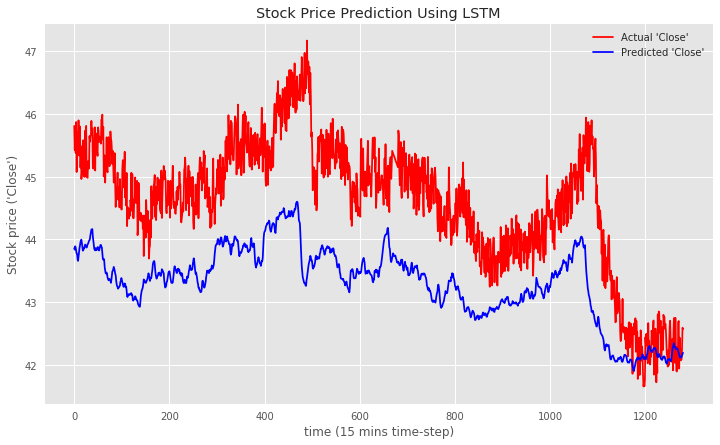

In [34]:
# Visualising the results
plt.figure(figsize=(12,7))
plt.plot(y_test, 'r-', label = "Actual 'Close'" )
plt.plot(y_pred, 'b-', label = "Predicted 'Close'")
plt.title('Stock Price Prediction Using LSTM')
plt.xlabel('time (15 mins time-step)')
plt.ylabel("Stock price ('Close')")
plt.legend()
plt.show()

### Final Comments
Once the future 'Close' price for the next time step is predicted, the future close return can be then be calculated using the actual and predicted data.

The model can capture the stock price () trend (i.e. whether the price will increase of decrease) very well and closely follows the actual price. However, there still some work need to be done in order to improve the accuracy of the LSTM model.